In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime
from xgboost import plot_importance, plot_tree
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
plt.style.use("fivethirtyeight")

In [2]:
# Load data.
fmt = lambda dates: datetime.strptime(dates, "%d/%m/%Y %H:%M")
train = pd.read_csv('./data/train.csv', index_col = [0], parse_dates = [1], date_parser = fmt)
test = pd.read_csv('./data/test.csv', index_col = [0], parse_dates = [1], date_parser = fmt)

In [3]:
trainReg = train
trainXgb = train
testReg = test
testXgb = test

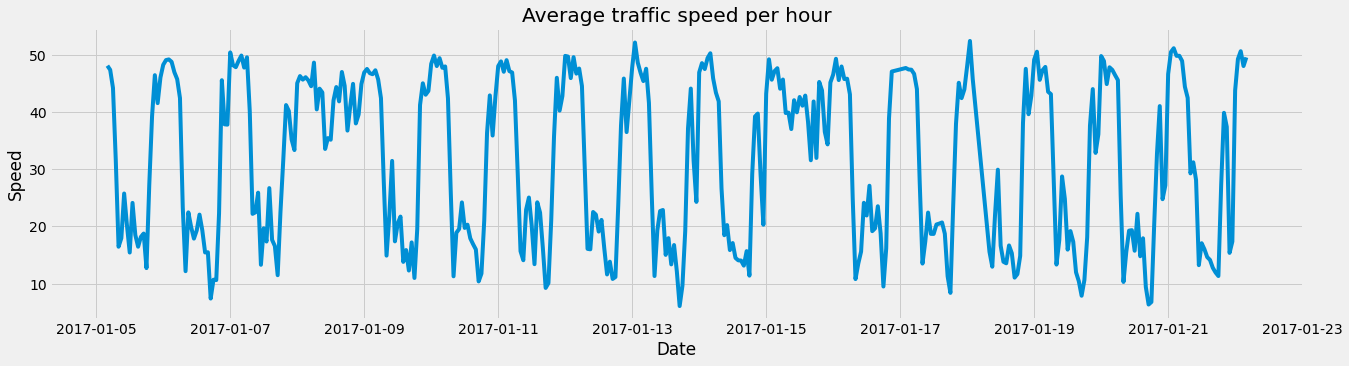

In [4]:
# Plot the time series between 100 and 500 to see the trend.
xx = train[100:500]["date"]
yy = train[100:500]["speed"]
plt.figure(figsize=(20, 5))
plt.plot(xx, yy)
plt.xlabel("Date")
plt.ylabel("Speed")
plt.title("Average traffic speed per hour")
plt.show()

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

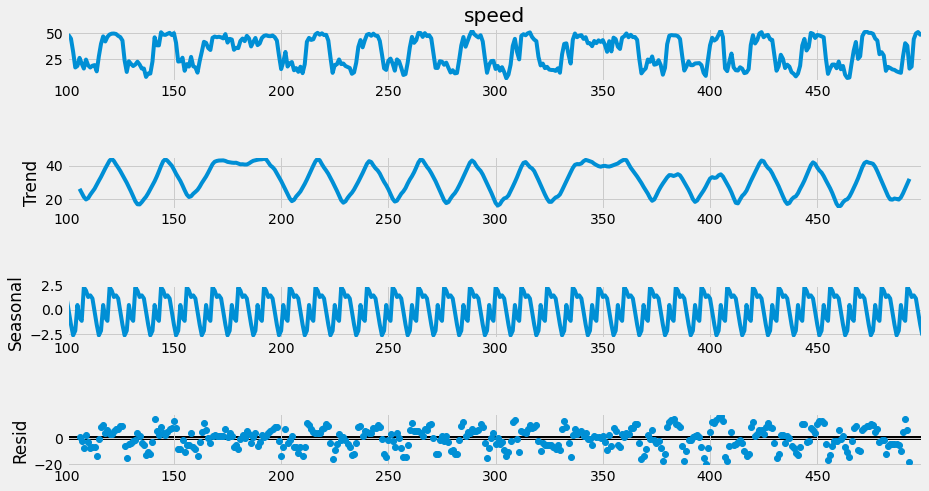

In [5]:
# Decompose the time series to see whether there are strong seasonal components.
# Time series do have a lot of seasonal components shown in the figure.
decomposition = seasonal_decompose(train[100:500]["speed"], freq = 12)
fig = plt.figure()
fig = decomposition.plot() 
fig.set_size_inches(15, 8)

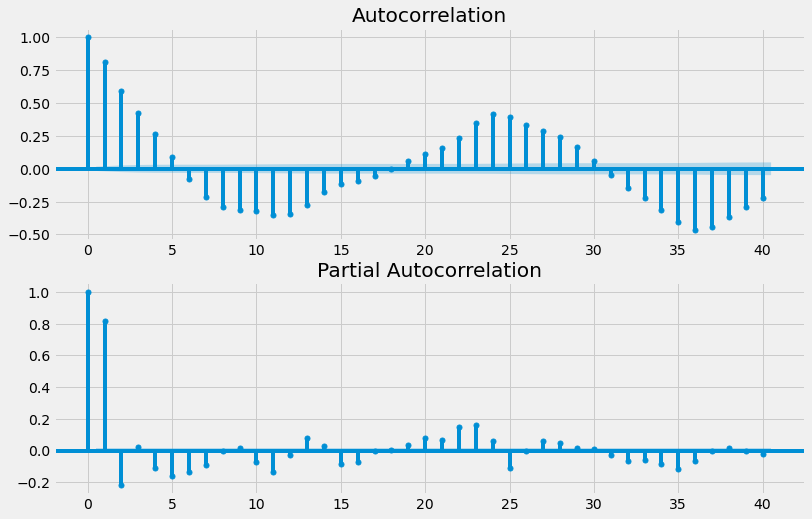

In [6]:
# plot the ACF and PACF to determine the p and q of ARIMA(p, d, q)
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train.speed, lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train.speed, lags = 40, ax = ax2)

In [7]:
# Time series requires the time stamps to be equally spaced.
# However, there are too many missing values in the lower half of the time series.
# (365 + 365) * 24 = 17520
# 14006 / 17520 = 0.7994
# More than 20% points are missing.
# So we cannot use time series by filling in such a large proportion of missing values.
train[12074:12100]

,date,speed
id,,
12074,2018-08-13 01:00:00,47.184858
12075,2018-08-13 03:00:00,47.412554
12076,2018-08-13 05:00:00,47.297991
12077,2018-08-13 07:00:00,33.639536
12078,2018-08-13 08:00:00,17.491419
12079,2018-08-13 10:00:00,22.843545
12080,2018-08-13 12:00:00,24.868700
12081,2018-08-13 16:00:00,25.925521
12082,2018-08-13 19:00:00,26.333895


In [8]:
# Generate features.
def generate_feature(df):
    df["hfd"] = df["date"].dt.hour # hour of a day
    df["dfw"] = df["date"].dt.dayofweek # day of a week
    df["dfm"] = df["date"].dt.day # day of a month
    df["dfy"] = df["date"].dt.dayofyear # day of a year
    df["wfy"] = np.int64(df["date"].dt.isocalendar().week) # week of a year
    df["mfy"] = df["date"].dt.month # month of a year
    df["qfy"] = df["date"].dt.quarter # quarter of a year
    
    x = df[["hfd", "dfw", "dfm", "dfy", "wfy", "mfy", "qfy"]]
    return x

In [9]:
x_train = generate_feature(train)
y_train = train["speed"]
x_test = generate_feature(test)

In [10]:
# Try regression.
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [11]:
testReg["speed"] = model.predict(x_test)

In [12]:
trainReg["speedReg"] = model.predict(x_train)

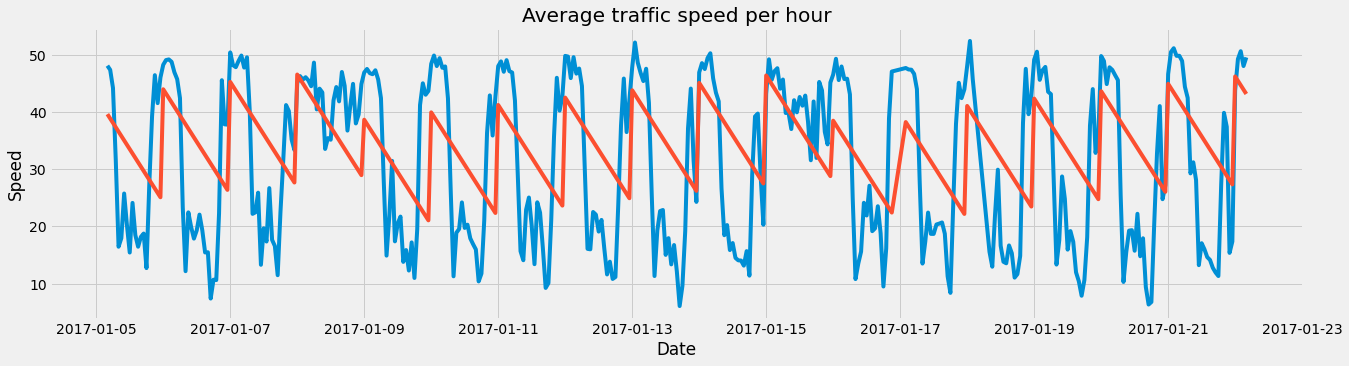

In [13]:
# Regression works bad.
xx = trainReg[100:500]["date"]
yy1 = trainReg[100:500]["speed"]
yy2 = trainReg[100:500]["speedReg"]
plt.figure(figsize=(20, 5))
plt.plot(xx, yy1)
plt.plot(xx, yy2)
plt.xlabel("Date")
plt.ylabel("Speed")
plt.title("Average traffic speed per hour")
plt.show()

In [14]:
# Try XGBoost.
params = {"max_depth": 8,
          "learning_rate": 0.1,
          "n_estimators": 300,
#          "gamma": 0,
#          "min_child_weight": 3,
          "objective": "reg:squarederror",
          "booster": "gbtree",
          "n_jobs": 4,
#          "max_delta_step": 0,
          "subsample": 0.7,
#          "colsample_bytree": 1,
#          "colsample_bylevel": 1,
#          "colsample_bynode": 1,
          "reg_alpha": 1,
          "reg_lambda": 1,
#          "scale_pos_weight": 0,
#          "base_score": 0.5,
#          "random_state": 0,
          "importance_type": "gain"}
model = xgb.XGBRegressor(**params)
model.fit(x_train, y_train, verbose = True)

XGBRegressor(max_depth=8, n_estimators=300, n_jobs=4,
             objective='reg:squarederror', reg_alpha=1, subsample=0.7)

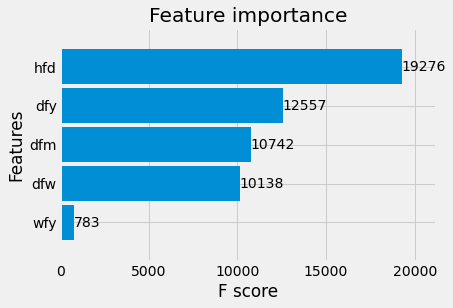

In [15]:
# Plot the importance of features.
# 
ipt = plot_importance(model, height = 0.9)

In [16]:
testXgb["speed"] = model.predict(x_test)

In [17]:
trainXgb["speedXgb"] = model.predict(x_train)

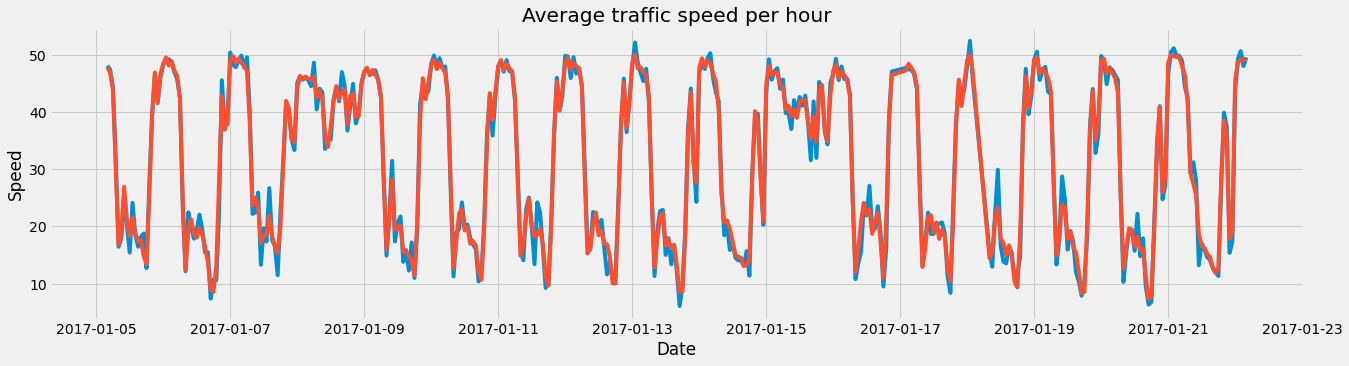

In [18]:
# XGBoost works well.
xx = trainXgb[100:500]["date"]
yy1 = trainXgb[100:500]["speed"]
yy2 = trainXgb[100:500]["speedXgb"]
plt.figure(figsize=(20, 5))
plt.plot(xx, yy1)
plt.plot(xx, yy2)
plt.xlabel("Date")
plt.ylabel("Speed")
plt.title("Average traffic speed per hour")
plt.show()

In [19]:
test = testXgb["speed"]

In [20]:
test.to_csv("./submissionXgb.csv", index = True, sep = ",")

In [ ]:
# Adjust parameter by Grid Search.
from sklearn.model_selection import GridSearchCV
cv_params = {"learning_rate": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
other_params = {"max_depth": 4,
                "learning_rate": 0.01,
                "n_estimators": 2000,
                "gamma": 0,
                "min_child_weight": 3,
                "objective": "reg:squarederror",
                "booster": "gbtree",
                "n_jobs": 4,
                "max_delta_step": 0,
                "subsample": 0.6,
                "colsample_bytree": 1,
                "colsample_bylevel": 1,
                "colsample_bynode": 1,
                "reg_alpha": 1,
                "reg_lambda": 0,
                "scale_pos_weight": 0,
                "base_score": 0.7,
                "importance_type": "gain"}

model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator = model, param_grid = cv_params, scoring = "r2", cv = 5, n_jobs = 4)
optimized_GBM.fit(x_train, y_train)
evalute_result = optimized_GBM.cv_results_
print("Result for every run:{0}".format(evalute_result), "\n")
print("Best param：{0}".format(optimized_GBM.best_params_), "\n")
print("Best model:{0}".format(optimized_GBM.best_score_), "\n")